In [1]:
import pandas as pd
import numpy as np
import pytraj as pyt
import csv
import ast
import datetime
import matplotlib.pyplot as plt
from modulos.MDS import cMDS
from modulos.plotting_functions import plot_mds_or_pca, plot_anotation_labels
from modulos.label_cdk2_confs import label_cdk2_conformations

/home/joel/anaconda3/envs/mds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Tabla de datos con las 402 estructuras

In [2]:
df_cdk2 = pd.read_csv("./B_DATOS/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO.csv", index_col = 0,
                     converters={"NameLigs": lambda x: ast.literal_eval(x),
                                "GapPos": lambda x: ast.literal_eval(x),
                                 "Date": lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d")),
                                 "NameLigs": lambda x: ast.literal_eval(x),
                                }, na_filter=False)
df_cdk2.set_index("PDB_ID", inplace=True)
df_cdk2.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
PDB_ID,,,,,,,,,,,,,,
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298.0,92.953020,2.0,"[8, 13]","[[36, 43], [149, 161]]",1.0,['STU'],STU,440.0
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0


### Carga de las 402 estructuras

In [3]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = "../ARCHIVOS/CRISTALES/TRAJ_CRISTALS_PDB/PDB_402_cdk2_PISANI_ALL.pdb"
traj_crystals = pyt.load(file_pdb_traj_pisani)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 4848.


### Etiquetado de las estructuras según su conformación

In [ ]:
# Función para etiquetar cada estructura
labels_cdk2 = label_cdk2_conformations(traj_crystals)
df_cdk2["Labels_conf"] = labels_cdk2
df_cdk2.head(5)

In [ ]:
df_cdk2.Labels_conf

### Subsecuencias de la proteína

In [5]:
from modulos.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",") # subsecuencia de la estructura secuendaria
pocket_residues = get_pocket_residues(sep=",")

&nbsp; 
### Filtrado de las estructuras usadas por Pisani (2016)
Existen **tres filtros** que debemos aplicar para tratar de seleccionar las mismas 255 estructuras de Pisiani. Dos de estos filtros los dan los autores:
- Todas las estructuras cuyo valor de **resolución sea menor o igual a 2.5 A**
- Todas las estructuras que **NO** carezcan de *ninguno* de los residuos que mencionan en su lista (residuos de Pisani).

Para aplicar el segundo filtro es necesaria la siguiente función:

In [6]:
# Filtrado de las estructuras
# Primera condición
res_25_A_o_menos = df_cdk2.Resolution <= 2.5

# Segunda condición
from modulos.find_gaps import is_a_gap
no_gaps_en_seq = df_cdk2.GapPos.apply( lambda x: is_a_gap(x, get_pisani_residues(x="list")) )

# Tercera condición: ¿Cuántas y cuáles de las estructuras se publicaron como máximo hasta 2015?
fecha_2015_o_menos = df_cdk2.Date.apply(lambda x:  x.year  <= 2015)

# Obtenemos los índices resultantes
frames_pisani = np.array((res_25_A_o_menos) & (no_gaps_en_seq) & (fecha_2015_o_menos))

&nbsp;
## Classical Multidimentional Scaling
### Matriz de disimilitud
#### RMSD alineando por residuos usados por Pisani
Utilizamos *pytraj* para generar la matrix de disimilitud con la métrica *RMSD* en las **255** estructuras usadas por Pisani.

In [7]:
# RMSD por pares de las 402 estructuras
pair_rmsd_402_struc = pyt.pairwise_rmsd( traj = traj_crystals, mask= F"(:{pisiani_residues})&(@CA)", metric="rmsd")

# Subset de RMSD por pares usando sólo sus 255 estructuras
pair_rmsd_pisani = pair_rmsd_402_struc[:, frames_pisani][frames_pisani, :]

**Matrices dedidimilitud**

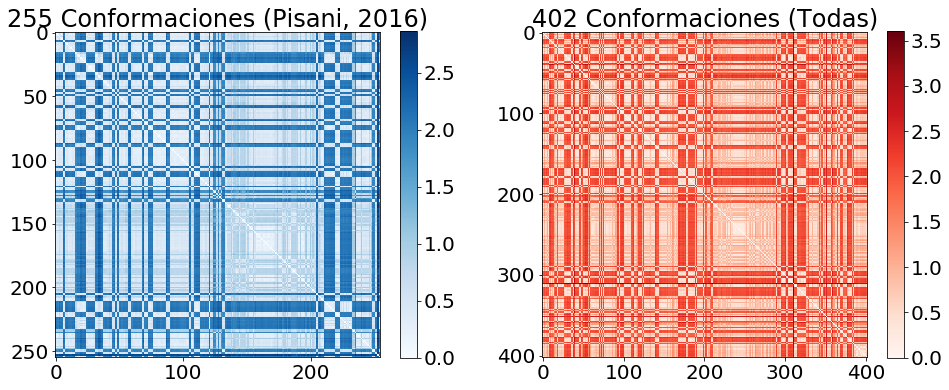

In [8]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 20})
plt.subplot(1, 2, 1)
plt.title("255 Conformaciones (Pisani, 2016)")
plt.imshow(pair_rmsd_pisani, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

plt.subplot(1, 2, 2)
plt.title("402 Conformaciones (Todas)")
plt.imshow(pair_rmsd_402_struc, zorder=2, cmap='Reds', interpolation='nearest')
plt.colorbar();

### Generación del cMDS
#### Ensamble de 255 estructuras cristalográficas de CDK2
Vamos a crear un ensamble con las 255 estructuras, a partir de los CA de las cadenas A de cada proteína. Al leer cada estructura sólo se tomarán en cuenta los CA, y para el análisis de RMSD y MSD sólo los residuos definidos por Pisani.

In [9]:
# MDS, usamos la función que previamente habíamos definido en moduloes.cMDS
mds_pisani = cMDS(pair_rmsd_pisani)

mds_total = cMDS(pair_rmsd_402_struc)

#### Estructuras de referencia

In [269]:
# Estructuras de  referencia que queremos mostrar en la gráfica
ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}

#### Gráfica de MDS de Pisani (2016)

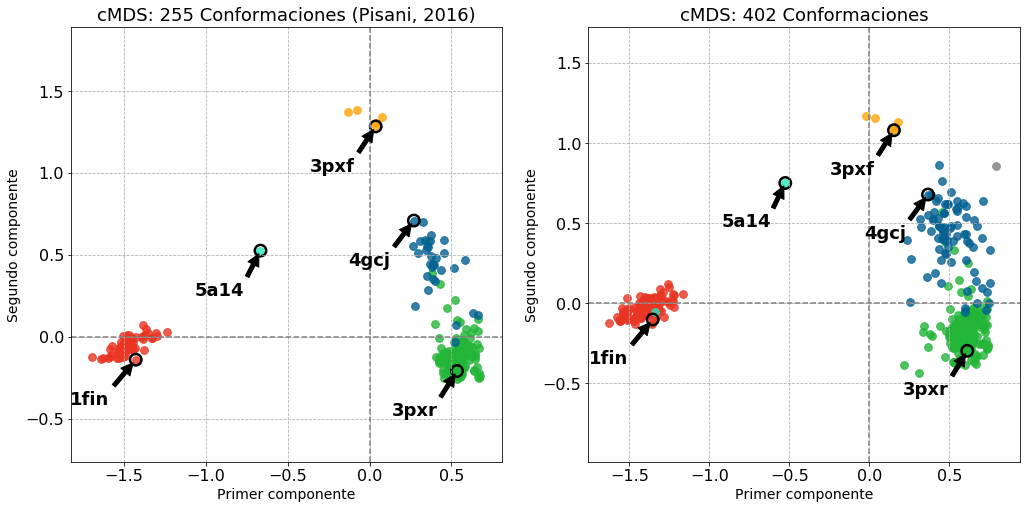

In [270]:
# Etiquetas según el PDB ID de cada estructura
traj_labels_pisani = df_cdk2.index[frames_pisani]
# Se genera la gráfica
fig = plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plot_mds_or_pca(mds = mds_pisani[0], labels = df_cdk2.Labels_conf[frames_pisani], alpha=0.8,
                             title = "cMDS: 255 Conformaciones (Pisani, 2016)")
plot_anotation_labels(df_cdk2.index[frames_pisani],  ref_structs_dict.keys(), 
                      mds_pisani[0][0], mds_pisani[0][1], xytext_delta=[0.4, 0.3], s=130)
 
plt.subplot(1, 2, 2)
plot_mds_or_pca(mds = mds_total[0], labels = df_cdk2.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 Conformaciones")
plot_anotation_labels(df_cdk2.index,  ref_structs_dict.keys(), mds_total[0][0], mds_total[0][1], xytext_delta=[0.4, 0.3], s=130)

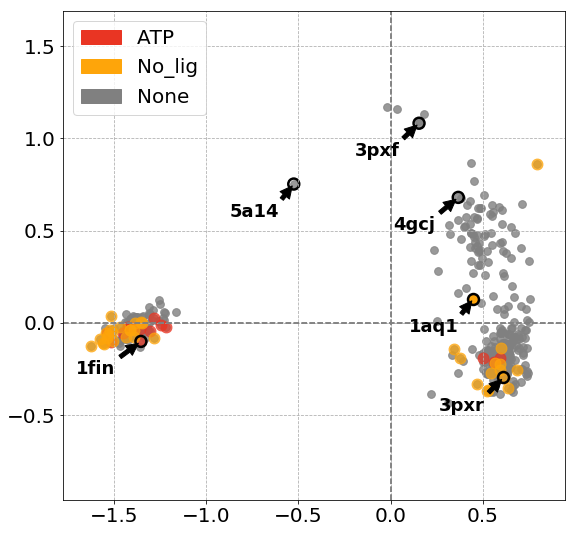

In [55]:
# Labels porligando acoplado
label_ligands = df_cdk2.Inhib.replace("", 'No_lig', regex=True)
# Ligandos que aparecen 2 o más veces
ligs_freq_n_times = pd.Series(label_ligands.value_counts()[label_ligands.value_counts() > 8]).index

ligand_labels = np.array([i if i in ligs_freq_n_times else "None" for i in label_ligands ])
ligand_colors = ['#E93523', '#FEA50A', 'gray']

fig = plt.figure(figsize=(9, 9))
plot_mds_or_pca(mds = mds_total[0], alpha = 0.8, colors_list=["gray"], general_font_size= 20)
plot_mds_or_pca(mds = mds_total[0], labels = ligand_labels, colors_list = ligand_colors, alpha = 0.7,
                legend=True, general_font_size= 20, xlabel="", ylabel="",
                title = "",  point_size=120,
                #title = "cMDS: 402 conf.\nColor por ligando (10 más frecuentes -incluyendo No_lig)"
               )
plot_anotation_labels(df_cdk2.index,ref_structs_dict.keys(), mds_total[0][0], mds_total[0][1], xytext_delta=[0.35, 0.2], s=120)
#plot_anotation_labels(df_cdk2.index, ["1aq1"], mds_total[0][0], mds_total[0][1], xytext_delta=[0.35, 0.2], s=120)

#### Plot RMSD vs primer frame

In [48]:
# Cálculo del RMSD contra el primer frame (estructura 1aq1)
rmsd_frame_1 = pyt.rmsd(traj_crystals, mask=F"@CA", ref=0, nofit = False, update_coordinate=False)

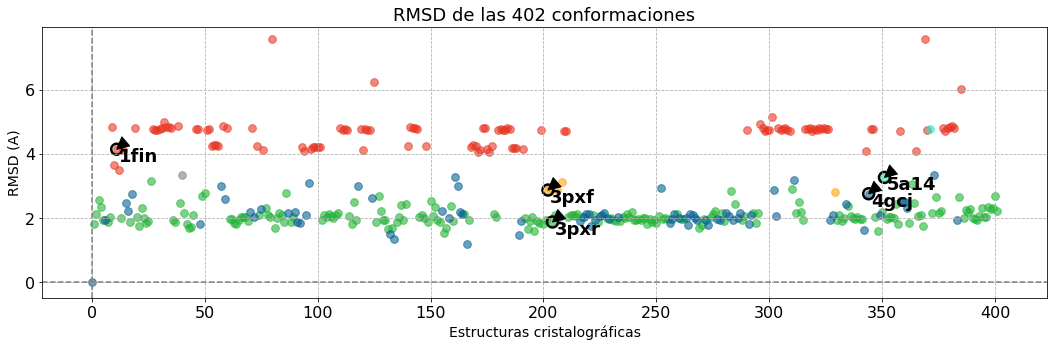

In [80]:
fig = plt.figure(figsize=(18, 5))
rmsd_plot = np.array([range(len(df_cdk2.Labels_conf)), rmsd_frame_1])
plot_mds_or_pca(rmsd_plot, labels = df_cdk2.Labels_conf, equal_axis=False,
                xlabel = "Estructuras cristalográficas", ylabel = "RMSD (A)", title = "RMSD de las 402 conformaciones")
plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), rmsd_plot[0], rmsd_plot[1], xytext_delta=[-1, 0.5], s=120)

&nbsp;
## Principal Component Analysis
#### Todos los $C\alpha$ de la secuencia vs $C\alpha$ de estructura secundaria (Pisani, 2016)
Para generar el PCA podemos usar *sklearn* o directamente el método *pca* de *pytraj*, los resultados son los mismos, y se pueden ver en la libreta de PCA. **Para cada subsecuencia evaluada la estructura es alineada previemente según dicha subsecuecia.**

In [82]:
# Todos los carbonos alfa
from sklearn.decomposition import PCA
pca_obj = PCA(copy=True, n_components= 2)

def get_pca(pca_obj, traj, frames = -1, atom_mask = "@CA"):
    ''' Retorna un objeto pca dada una trayectoria de pytraj y una mascara de selección'''
    traj_subset = traj_crystals[frames, atom_mask]
    xyz_2d_array = traj_subset.xyz.reshape(traj_subset.n_frames, traj_subset.n_atoms * 3)
    pca = pca_obj.fit_transform( xyz_2d_array )
    return pca

- **PCA con todos los átomos:**

In [83]:
pyt.align(traj_crystals, "@CA")
pca_pyt_all = get_pca(pca_obj, traj_crystals, frames_pisani, "@CA")
# pca_pyt_all = pyt.pca( traj_crystals[frames_pisani], mask = "@CA", n_vecs=-1)

- **PCA con subsecuencia de Pisani:**

In [84]:
# Carbonos alfa de la subsecuencia de Pisani
pyt.align(traj_crystals, F"(:{pisiani_residues})&(@CA)")
pca_pyt_pisani  = get_pca(pca_obj, traj_crystals, frames_pisani, F"(:{pisiani_residues})&(@CA)")
# pca_pyt_pisani = pyt.pca( traj_crystals[frames_pisani], mask = F"(:{pisiani_residues})&(@CA)", n_vecs=-1)

- **PCA con la subsecuencia del _sitio activo_ (todos los $C\alpha$ del sitio activo)**

In [85]:
# Usando todos los carbonos alfa del pocket
pyt.align(traj_crystals, F"(:{pocket_residues})&(@CA)")
pca_pyt_pocket = get_pca(PCA(copy=True, n_components= 2), traj_crystals, frames_pisani, F"(:{pocket_residues})&(@CA)")
# pca_pyt_pocket = pyt.pca( traj_crystals[frames_pisani], mask = F"(:{pocket_residues})&(@CA)", n_vecs=-1)

- **PCA con la subsecuencia del _sitio activo_ (sólo $C\alpha$ de las estructuras secundarias)**  
Antes de hacer el análisis se determina que parte de la subsecuencia del sitio activo corresponde a regiones con estructura secundaria.

In [86]:
# Los índices indican [1] secuencia sec. en string, y [0] = frame 1
sec_secundaria_cdk2_f1 = pyt.dssp_analysis.dssp(traj_crystals, "@CA")[1][0]
# Obtenemos los residuos del pocket
struct_pocket = sec_secundaria_cdk2_f1[get_pocket_residues("list")]
# Cremos la lista de índices
secondary_pk_index = [ j for i, j in zip(struct_pocket, get_pocket_residues("list")) if i != '0' ]
secondary_pk_index_string = ",".join([str(i) for i in secondary_pk_index])

In [87]:
# Usando todos los carbonos alfa del pocket
pyt.align(traj_crystals, F"(:{secondary_pk_index_string})&(@CA)")
pca_pyt_pocket_sec = get_pca(PCA(copy=True, n_components= 2), traj_crystals, frames_pisani, F"(:{secondary_pk_index_string})&(@CA)")
# pca_pyt_pocket = pyt.pca( traj_crystals[frames_pisani], mask = F"(:{pocket_residues})&(@CA)", n_vecs=-1)

&nbsp;
### Gráficas del PCA con 255 estructuras de Pisani
Las siguientes graficas evaluan las 255 estructuras utilizadas por Pisani.

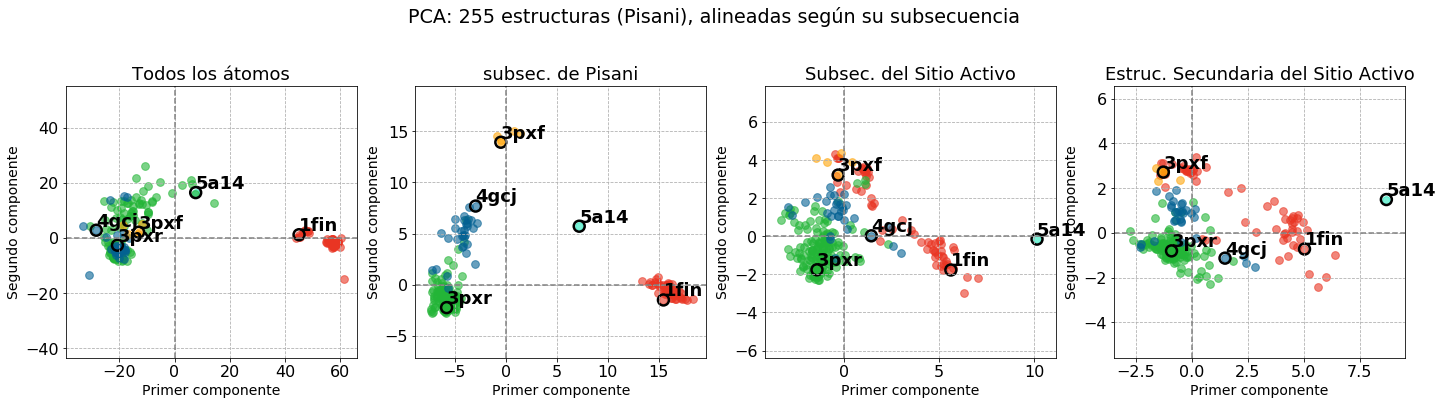

In [93]:
fig = plt.figure(figsize=(24, 5))
def plot_pca_pisani_structs(models, titles = ["Todos los átomos", "subsec. de Pisani", "Subsec. del Sitio Activo",
                                    "Estruc. Secundaria del Sitio Activo"]):
    for i, model in enumerate(models):
        plt.subplot(1, 4, i + 1)
        plot_mds_or_pca(mds = model.T, labels = df_cdk2[frames_pisani].Labels_conf,
                                     title = titles[i])
        plot_anotation_labels(df_cdk2[frames_pisani].index, ref_structs_dict.keys(), model.T[0], model.T[1], xytext_delta=[-0.0, 0.0], s=120)

plot_pca_pisani_structs([pca_pyt_all, pca_pyt_pisani, pca_pyt_pocket, pca_pyt_pocket_sec])
plt.suptitle("PCA: 255 estructuras (Pisani), alineadas según su subsecuencia", y = 1.1);

#### Diferentes subsets para el PCA a partir del mismo subset de alineamiento
Las gráficas de abajo evalúan  cómo cambian los resultados cuando **las estructuras son superpuestas utilizando un _subset_ de átomos** (por ejemplo las estructuras secundarias de Pisani) pero el **PCA es generado usando otro _subset_** de átomos.

In [94]:
def generate_new_aligns_pisani_structures(traj, mask_align):
    temp_traj = traj.copy()
    pyt.align(traj, mask_align)
    pca_pyt_all = get_pca(pca_obj, traj_crystals, frames_pisani, "@CA")
    pca_pyt_pisani  = get_pca(pca_obj, traj_crystals, frames_pisani, F"(:{pisiani_residues})&(@CA)")
    pca_pyt_pocket = get_pca(PCA(copy=True, n_components= 2), traj_crystals, frames_pisani, F"(:{pocket_residues})&(@CA)")
    pca_pyt_pocket_sec = get_pca(PCA(copy=True, n_components= 2), traj_crystals, frames_pisani, F"(:{secondary_pk_index_string})&(@CA)")
    
    plot_pca_pisani_structs([pca_pyt_all, pca_pyt_pisani, pca_pyt_pocket, pca_pyt_pocket_sec])

### Alineadas por todos los residuos

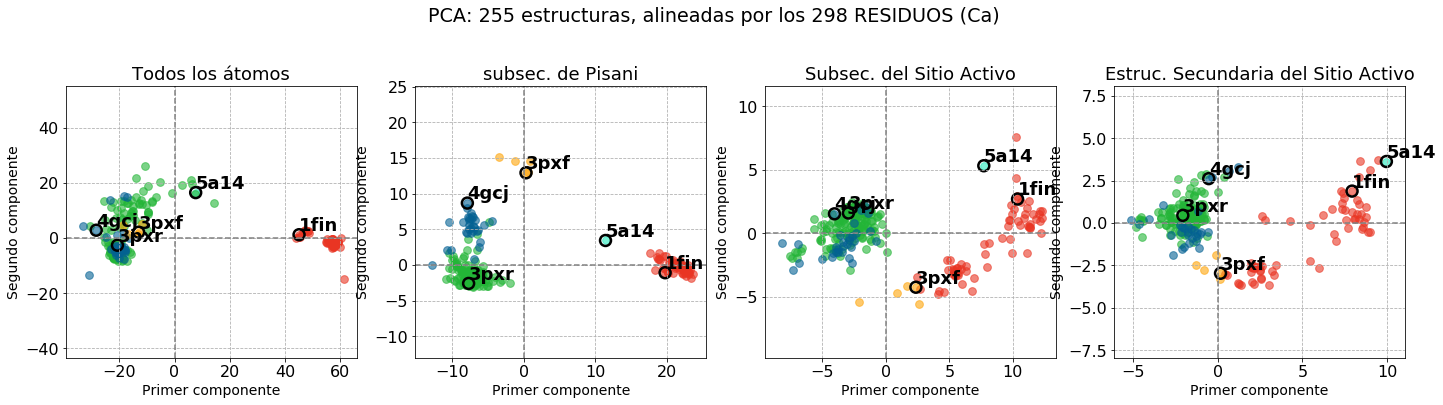

In [95]:
fig = plt.figure(figsize=(24, 5))
generate_new_aligns_pisani_structures( traj_crystals, "@CA")
plt.suptitle("PCA: 255 estructuras, alineadas por los 298 RESIDUOS (Ca)", y = 1.1);

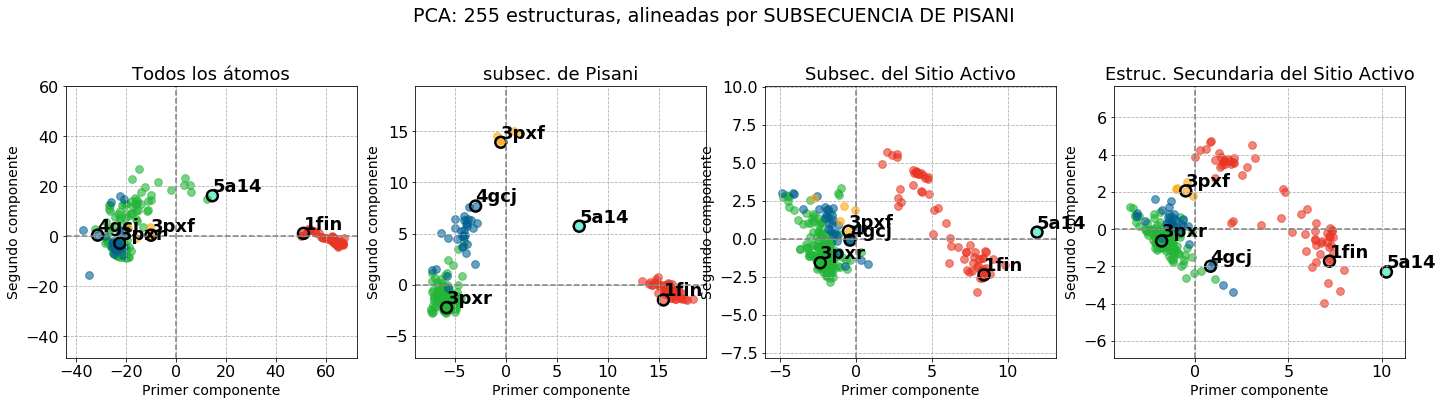

In [96]:
fig = plt.figure(figsize=(24, 5))
generate_new_aligns_pisani_structures( traj_crystals, F"(:{pisiani_residues})&(@CA)")
plt.suptitle("PCA: 255 estructuras, alineadas por SUBSECUENCIA DE PISANI", y = 1.1);

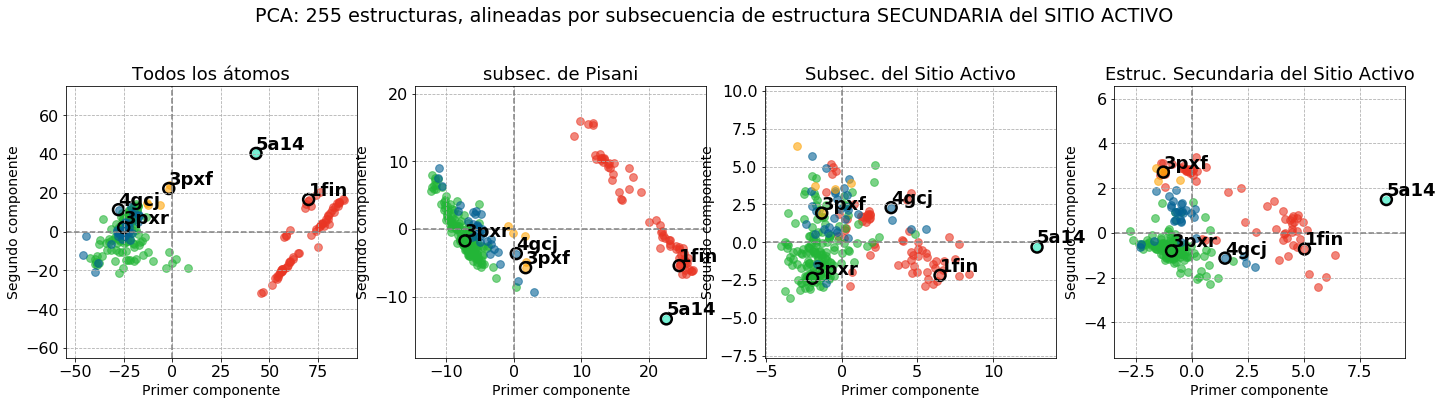

In [97]:
fig = plt.figure(figsize=(24, 5))
generate_new_aligns_pisani_structures( traj_crystals, F"(:{secondary_pk_index_string})&(@CA)")
plt.suptitle("PCA: 255 estructuras, alineadas por subsecuencia de estructura SECUNDARIA del SITIO ACTIVO", y = 1.1);

### Sitio activo etiquetado por ligando

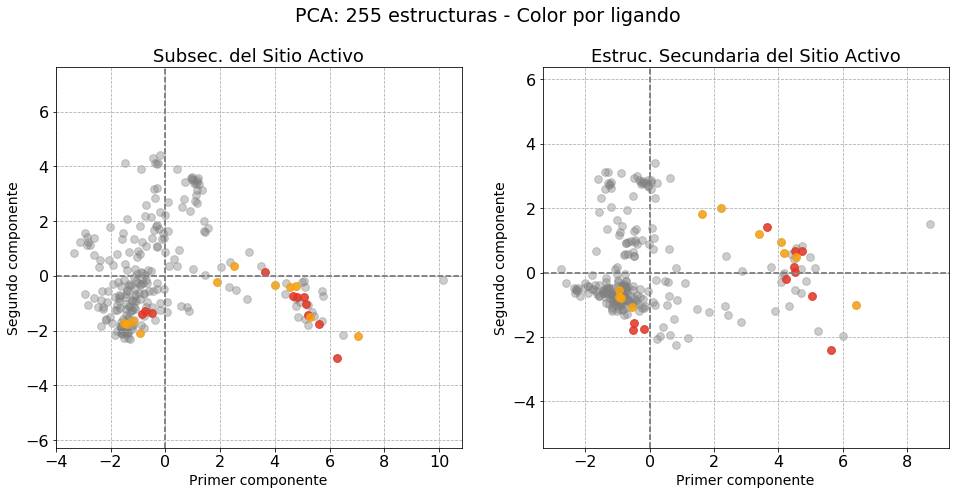

In [100]:
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plot_mds_or_pca(mds = pca_pyt_pocket.T, alpha = 0.4, colors_list=["gray"])
plot_mds_or_pca(mds = pca_pyt_pocket.T, labels = ligand_labels[frames_pisani], 
                colors_list = ligand_colors, alpha = 0.8,
                #dic_of_ref_labels = ref_structs_dict, traj_labels = df_cdk2[frames_pisani].index,
                             title = "Subsec. del Sitio Activo")
plt.subplot(1, 2, 2)
plot_mds_or_pca(mds = pca_pyt_pocket_sec.T, alpha = 0.4, colors_list=["gray"])
plot_mds_or_pca(mds = pca_pyt_pocket_sec.T, labels = ligand_labels[frames_pisani], 
                colors_list = ligand_colors, alpha = 0.8,
                #dic_of_ref_labels = ref_structs_dict, traj_labels = df_cdk2[frames_pisani].index,
                             title = "Estruc. Secundaria del Sitio Activo")
plt.suptitle("PCA: 255 estructuras - Color por ligando", y =1);

## cMDS usando POVME3
#### Evaluación directa del volumen del ligando

In [107]:
# Cargamos los valores del volumen del pocket
volumen_402_stc = pd.read_csv('../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_PISANI_402/res_volumes.tabbed.txt', sep = "\t", header=None)
volumen_402_stc.columns = ['frames', 'pocket_volume']
volumen_402_stc.frames = np.arange(0, len(volumen_402_stc.pocket_volume))
volumen_402_stc = np.array(volumen_402_stc).T

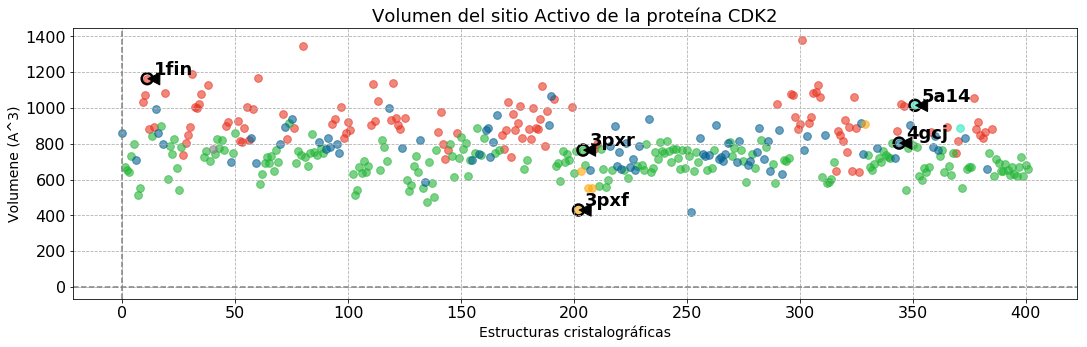

In [112]:
fig = plt.figure(figsize=(18, 5))
plot_mds_or_pca(volumen_402_stc, labels = df_cdk2.Labels_conf,
                equal_axis=False, xlabel = "Estructuras cristalográficas", ylabel = "Volumene (A^3)", 
                title = "Volumen del sitio Activo de la proteína CDK2")
plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), volumen_402_stc[0], volumen_402_stc[1], xytext_delta=[-3, 0.5], s=120)

#### Disimilitud del sitio activo por forma del pocket

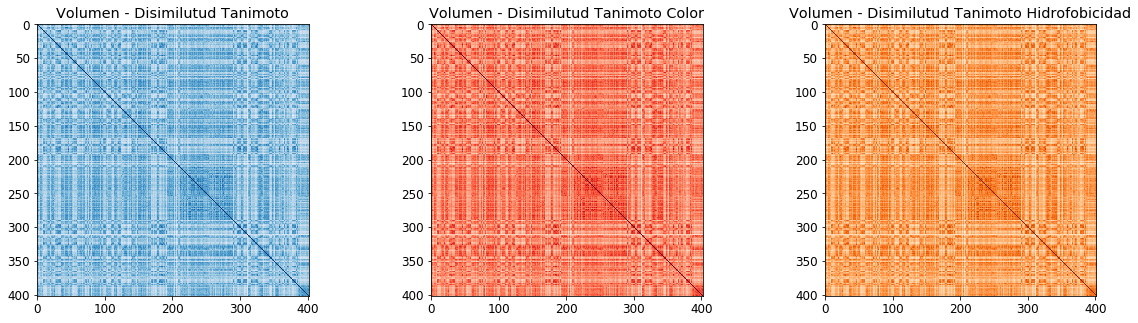

In [113]:
dir_volumen_results = '../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_PISANI_402/res_frameInfo/'

vol_tan_mtx = pd.read_csv(dir_volumen_results + 'POVME_Tanimoto_matrix.csv', header=None)
vol_tan_col_mtx = pd.read_csv(dir_volumen_results + 'POVME_Tanimoto_matrix_colored.csv', header=None)
vol_tan_hyfb_mtx = pd.read_csv(dir_volumen_results +'POVME_Tanimoto_matrix_hydrophobic.csv', header=None)

# visualizamos las matrices de volumen V
fig = plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 12})
plt.subplot(1, 3, 1)
plt.imshow(vol_tan_mtx , zorder=2, cmap='Blues', interpolation='nearest')
plt.title("Volumen - Disimilutud Tanimoto")
plt.subplot(1, 3, 2)
plt.imshow(vol_tan_mtx , zorder=2, cmap='Reds', interpolation='nearest')
plt.title("Volumen - Disimilutud Tanimoto Color")
plt.subplot(1, 3, 3)
plt.imshow(vol_tan_mtx , zorder=2, cmap='Oranges', interpolation='nearest')
plt.title("Volumen - Disimilutud Tanimoto Hidrofobicidad");

### cMDS utilizando el VOLUMEN


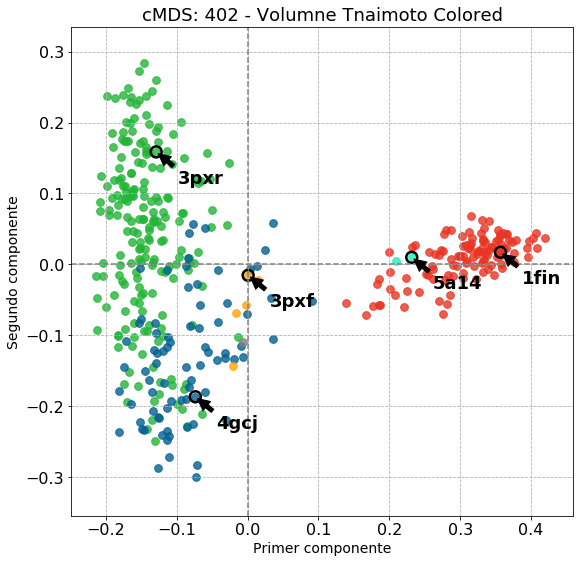

In [154]:
cdk2_tanimoto_vol_col = pd.read_csv(F'{dir_volumen_results}POVME_Tanimoto_matrix_colored.csv', header = None)
# Se calcula el cMDS usando la matriz de tanimoto menos uno
mds_tanimoto_vol_col = cMDS(cdk2_tanimoto_vol_col - 1)
# Plotting
fig = plt.figure(figsize=(9, 9))
plot_mds_or_pca(mds = mds_tanimoto_vol_col[0], labels = df_cdk2.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 - Volumne Tnaimoto Colored")
plot_anotation_labels(df_cdk2.index,ref_structs_dict.keys(), mds_tanimoto_vol_col[0][0], 
                      mds_tanimoto_vol_col[0][1], xytext_delta=[-0.03, 0.05], s=120)

#### Gráficos de MDS utilizando diferentes propiedades de POVME
Primero usamos una función sencilla que realice el proceso de MDS y graficado a partir de un archivo *.csv* con la matriz de disimilitud.

In [134]:
def plot_mds_volumen(path, titulo):
    vol_tan_mtx = pd.read_csv(path, header=None)
    mds_total_vol = cMDS(vol_tan_mtx - 1)
    plot_mds_or_pca(mds = mds_total_vol[0], labels = df_cdk2.Labels_conf, title = titulo)
    plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), 
                          mds_total_vol[0][0], mds_total_vol[0][1], xytext_delta=[-0.03, 0.1], s=120)

### Plots utilizando la métrica Tanimoto

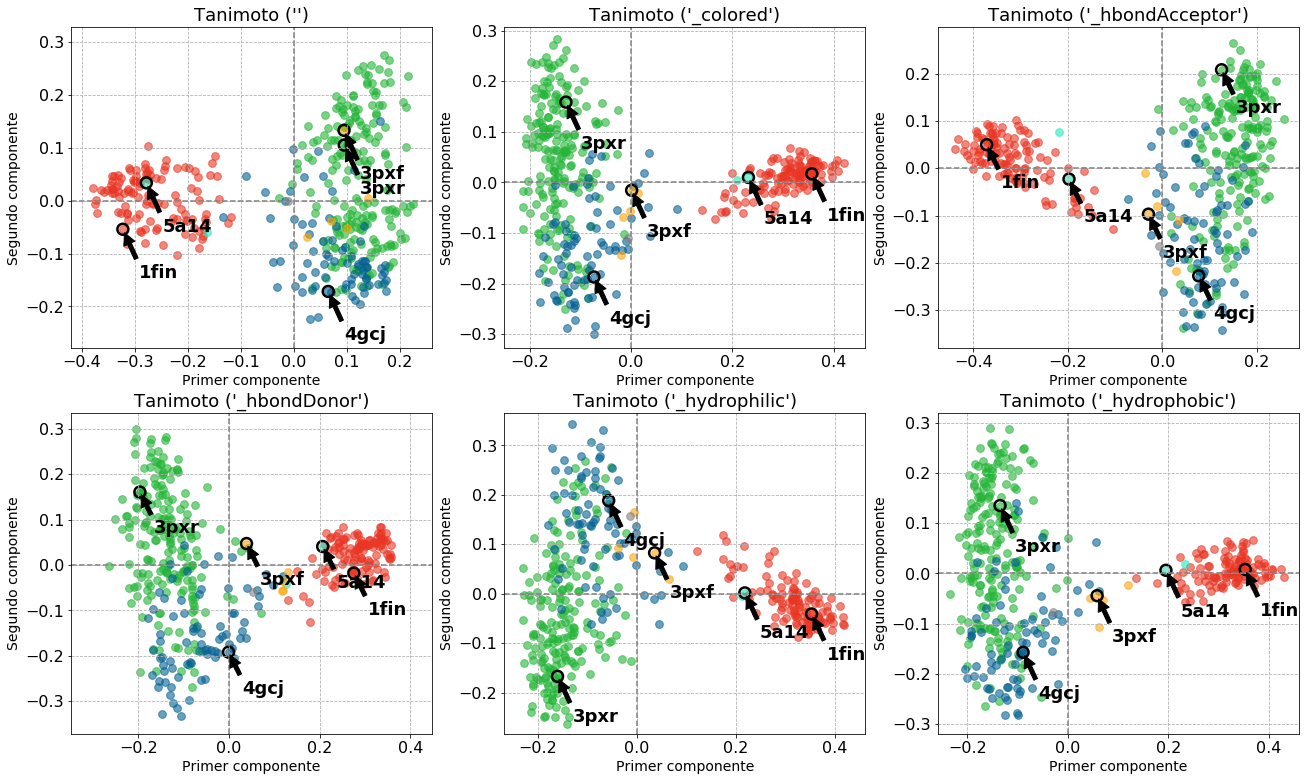

In [135]:
fig = plt.figure(figsize=(22, 13))
propiedades = ["", "_colored", "_hbondAcceptor", "_hbondDonor", "_hydrophilic", "_hydrophobic"]
for i, propiedad in enumerate(propiedades):
    plt.subplot(2, 3, i + 1)
    plot_mds_volumen(F'{dir_volumen_results}POVME_Tanimoto_matrix{propiedad}.csv', F"Tanimoto ('{propiedad}')")

### Plots utilizando la métrica Tversky

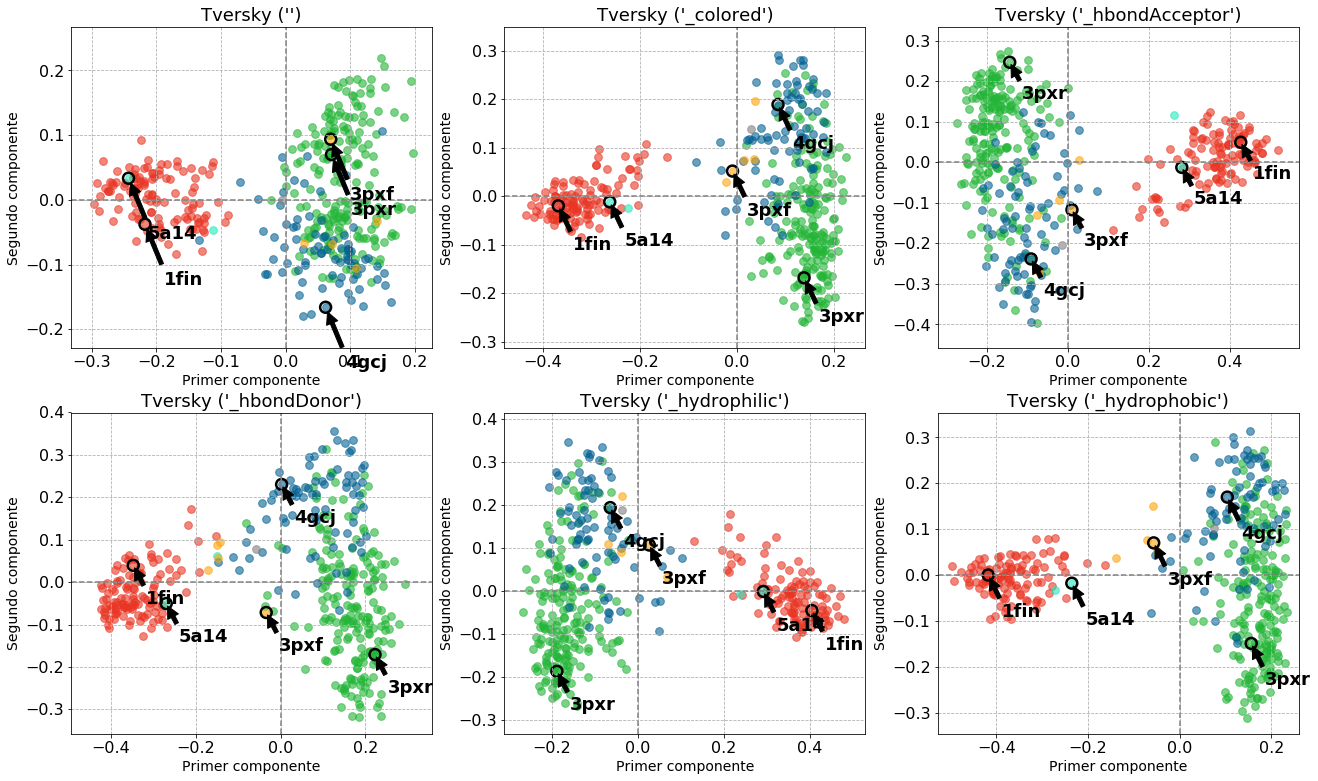

In [139]:
fig = plt.figure(figsize=(22, 13))
propiedades = ["", "_colored", "_hbondAcceptor", "_hbondDonor", "_hydrophilic", "_hydrophobic"]
for i, propiedad in enumerate(propiedades):
    plt.subplot(2, 3, i + 1)
    plot_mds_volumen(F'{dir_volumen_results}POVME_Tversky_matrix{propiedad}.csv', F"Tversky ('{propiedad}')")

### Combinando dos mediadas de disimilitud

In [262]:
# Juntamos las primeras dos dimensiones de cada MDS generado (RMSD y de Volumen con Tanimoto)
from scipy.spatial.distance import pdist, squareform
from scipy import stats

# Unimos las cuator dimensiones ( dos por cada MDS) y hacemos el reshape
new_dims_rd_vol = np.vstack((mds_total[0][0:2], mds_tanimoto_vol_col[0][0:2]**4)).T
d = pdist(new_dims_rd_vol,  'euclidean') # Calcula las distancias por pares
D = squareform(d) # Reorganiza los datos en una matrix cuadrada

print(mds_tanimoto_vol_col[0][0:2])
print(stats.zscore(mds_tanimoto_vol_col[0][0]))

[[ 0.00330538 -0.15825163 -0.1638801  ... -0.14313224 -0.13339918
  -0.14580249]
 [-0.00666741  0.15790138  0.12951044 ...  0.16048712  0.07329898
   0.28402571]]
[ 0.01633478 -0.78206027 -0.80987546 ... -0.70734209 -0.65924245
 -0.7205381 ]


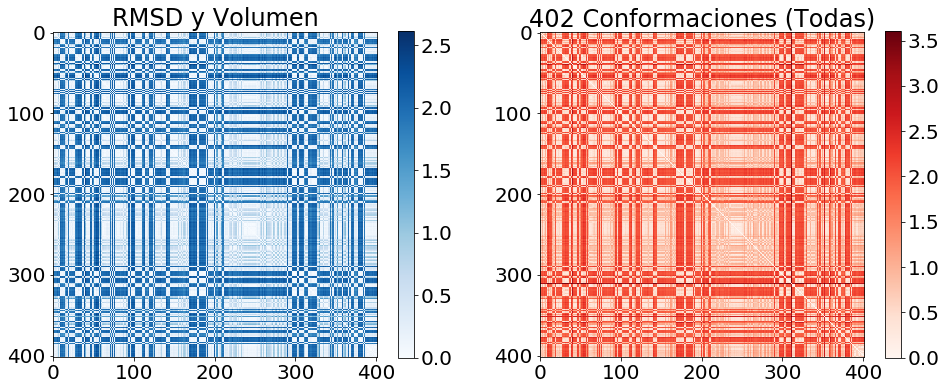

In [263]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 20})
plt.subplot(1, 2, 1)
plt.title("RMSD y Volumen")
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

plt.subplot(1, 2, 2)
plt.title("402 Conformaciones (Todas)")
plt.imshow(pair_rmsd_402_struc, zorder=2, cmap='Reds', interpolation='nearest')
plt.colorbar();

In [264]:
new_cmds = cMDS(D)

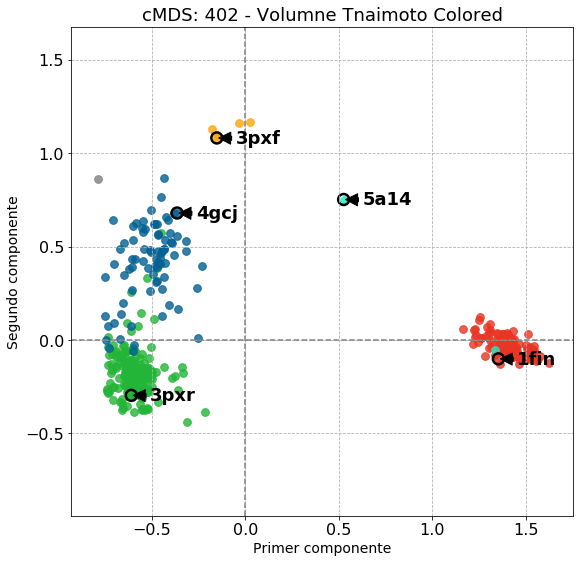

In [265]:
# Plotting
fig = plt.figure(figsize=(9, 9))
plot_mds_or_pca(mds = new_cmds[0], labels = df_cdk2.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 - Volumne Tnaimoto Colored")
plot_anotation_labels(df_cdk2.index,ref_structs_dict.keys(), new_cmds[0][0], 
                      new_cmds[0][1], xytext_delta=[-0.1, 0.05], s=120)